In [1]:
import geopandas as gpd
import xarray as xr
from rasterio import features
from affine import Affine
import numpy as np
import salem
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import matplotlib.dates as mdates
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# MBNMS Chlorophyll-a #

Monthly surface Chlorophyll-a data ranging from `2002-2019` was collected from the [Coastwatch Thredds server](https://oceanwatch.pfeg.noaa.gov/thredds/Satellite/aggregsatSA/chla/catalog.html).

Data are lazy-loaded (meaning not downloaded into memory) into an xarray dataset wrapped with Salem. A mask is created from a shape file of the sanctuary and a spatial mean is taken for each month, creating a monthly timeseries.

__Load MBNMS Shape file data__

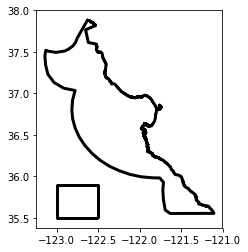

In [2]:
shdf= salem.read_shapefile("./mbnms shapefiles/mbnms_py2/mbnms_py.shp")
bbox = shdf.bounds
shdf.plot(lw=3,edgecolor='k',color='None')

In [15]:
shdf['geometry']

0    (POLYGON ((-122.5000000001226 35.5000000037708...
Name: geometry, dtype: object

__Lazy load Monthly Modis Chl-a data from Coastwatch Thredds__

This is a global products, so to make it more manageable, the dataset gets split up into the bounding box around the MBNMS.

In [6]:
fname = "https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/satellite/MH1/chla/mday"
dsw = salem.open_xr_dataset(fname)
dsw = dsw.sel(lat=slice(bbox.maxy[0],bbox.miny[0]),lon=slice(bbox.minx[0],bbox.maxx[0])) # lat goes north to south hear slice(34,32)
dsw.load()

<xarray.Dataset>
Dimensions:  (eightbitcolor: 256, lat: 57, lon: 49, rgb: 3, time: 194)
Coordinates:
  * lat      (lat) float32 37.854168 37.8125 37.770832 37.729168 37.6875 ...
  * lon      (lon) float32 -123.104164 -123.06249 -123.02083 -122.979164 ...
  * time     (time) datetime64[ns] 2003-01-16 2003-02-16 2003-03-16 ...
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    palette  (rgb, eightbitcolor) float32 147.0 0.0 108.0 144.0 0.0 111.0 ...
    chlor_a  (time, lat, lon) float32 2.123468 2.123468 2.516722 2.728228 ...
Attributes:
    product_name:                                          A20190012019031.L3...
    instrument:                                            MODIS
    title:                                                 MODISA Level-3 Sta...
    project:                                               Ocean Biology Proc...
    platform:                                              Aqua
    temporal_range:                                        month
 

Lets do a quick plot to see the first slice of data

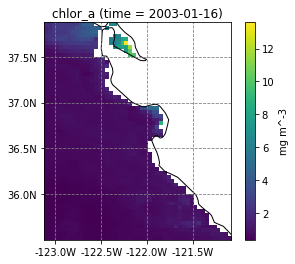

In [7]:
dsw['chlor_a'].isel(time=0).salem.quick_map()

Now, we want to use the sanctuary shape file to make a mask of the data

In [8]:
dsr = dsw.salem.roi(shape=shdf)
lons,lats = np.meshgrid(dsr['lon'].values,dsr['lat'].values)

Lets plot the average through time

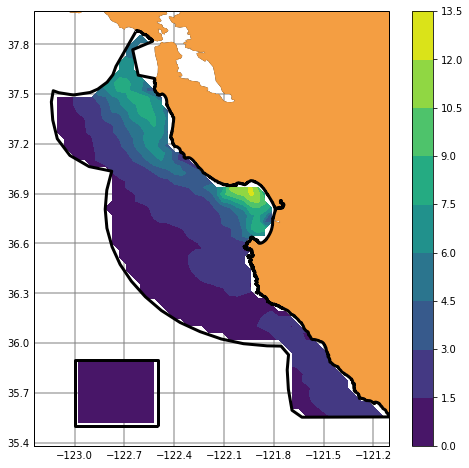

In [9]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='#f49e42'))
cax = ax.contourf(lons,lats,dsr['chlor_a'].median(dim='time'),zorder=2)
shdf.plot(ax=ax,lw=3,edgecolor='k',color='None',zorder=10)
plt.colorbar(cax)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False

__Plot timeseries of spatial mean and median__

In [42]:
mean_ts = dsr['chlor_a'].mean(dim=['lat','lon'])
sts_ts = dsr['chlor_a'].std(dim=['lat','lon'], ddof=1)
median = mean_ts.median().values
print(median)
mean = mean_ts.mean().values
print(mean)
std = mean_ts.std(ddof=1).values
print(std)

3.1845688819885254
3.538395404815674
1.9684339761734009


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5,0,'')

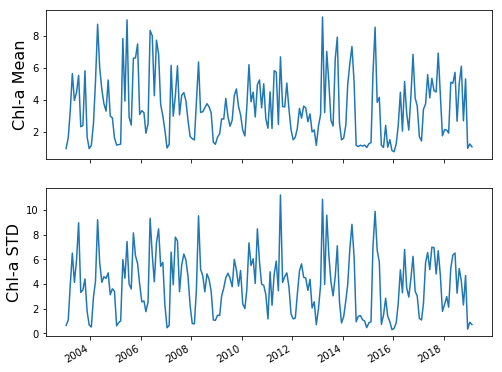

In [43]:
fig, (ax,ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,6)
mean_ts.plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Chl-a Mean',size=16)
sts_ts.plot(ax=ax2)
ax2.set_ylabel('Chl-a STD',size=16)
ax2.set_xlabel('')

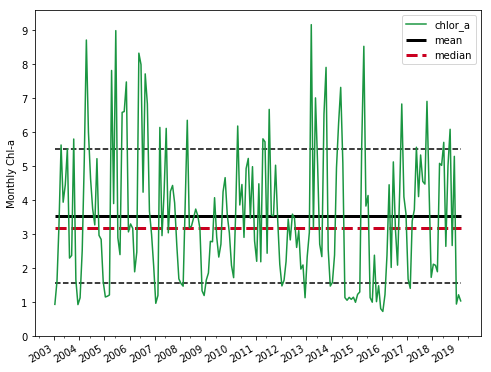

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
mean_ts.plot(ax=ax,color='#1a9641')
ax.hlines(mean,mean_ts['time'][0].values,mean_ts['time'][-1].values,label='mean',lw=3)
ax.hlines(mean+std,mean_ts['time'][0].values,mean_ts['time'][-1].values,linestyle='dashed')
ax.hlines(mean-std,mean_ts['time'][0].values,mean_ts['time'][-1].values,linestyle='dashed')
ax.hlines(median,mean_ts['time'][0].values,mean_ts['time'][-1].values,linestyle='dashed',label='median',color='#ca0020',lw=3)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(6))
ax.set_xlabel('')
ax.set_ylabel('Monthly Chl-a')
ax.set_yticks(range(0,10))
plt.legend()

__Plot annual sum__

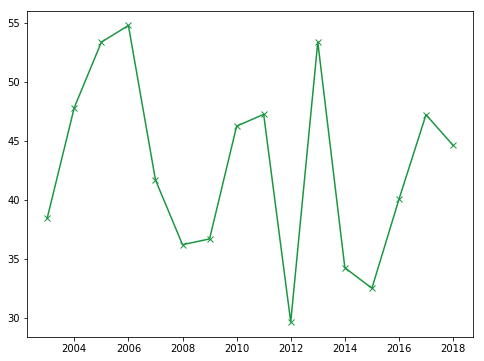

In [45]:
mean_df = mean_ts.to_pandas()
annual_sum = mean_df.resample('Y').sum()
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.plot(annual_sum.index.year[:-1],annual_sum[:-1],color='#1a9641',marker='x')

(array([18., 16., 14., 20., 14., 19., 16., 11., 14.,  4., 14.,  6.,  7.,
         5.,  5.,  1.,  3.,  2.,  3.,  2.]),
 array([0.7352539, 1.1569382, 1.5786226, 2.000307 , 2.4219913, 2.8436759,
        3.26536  , 3.6870446, 4.108729 , 4.530413 , 4.952098 , 5.373782 ,
        5.7954664, 6.2171507, 6.6388354, 7.0605197, 7.482204 , 7.903888 ,
        8.325573 , 8.747257 , 9.1689415], dtype=float32),
 <a list of 20 Patch objects>)

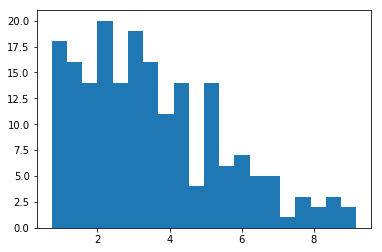

In [46]:
fig, ax = plt.subplots()
ax.hist(mean_ts,bins=20)

__Plot monthly Cummulative sum__

Cummulative sums can be another way of displaying this data. The slope will tell us about monthly variation and the magitude can be used to compare across years

In [47]:
df = mean_ts.to_pandas()
df = pd.DataFrame(data={'mean':df})
df['year'] = df.index.year
df['month'] = df.index.month
df['cum_sum'] = df.groupby("year")['mean'].cumsum()

In [51]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.nanmean(a), stats.sem(a, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def df_ci(series_name,df,hour_series):
    """ Return the mean, and 95% confidence intervals """
    ci_mean = []
    ci_lower = []
    ci_upper = []
    for hr in range(1,13):
        v_outer = df[df[hour_series]==hr][series_name]
        ci = mean_confidence_interval(v_outer, confidence=0.95)
        ci_mean.append(ci[0])
        ci_lower.append(ci[1])
        ci_upper.append(ci[2])
    return ci_mean, ci_lower, ci_upper

In [52]:
mean_ci =  df_ci('cum_sum', df,hour_series='month')

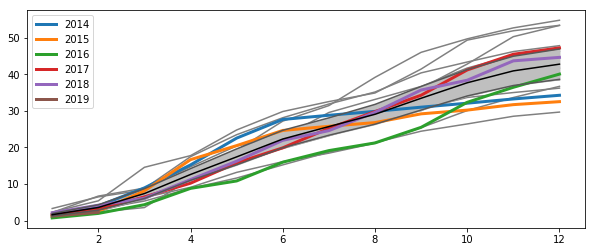

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
grouped = df.groupby('year')
for name, group in grouped:
    if name >= 2014:
        ax.plot(group['month'],group['mean'].cumsum(skipna=True),label=name,lw=3)
    else:
        ax.plot(group['month'],group['mean'].cumsum(skipna=True),label='_nolegend_',color='.5',zorder=-1)
ax.fill_between(list(range(1,13)),mean_ci[1],mean_ci[2],color='.75')
ax.plot(list(range(1,13)),mean_ci[1],color='.34')
ax.plot(list(range(1,13)),mean_ci[2],color='.34')
ax.plot(list(range(1,13)),mean_ci[0],color='k')
# ax.set_ylim(0)
plt.legend()

## Altair weather Chl-a
[Example Plot](https://altair-viz.github.io/gallery/weather_heatmap.html)

In [75]:
import altair as alt
from vega_datasets import data
df_mean = dsr['chlor_a'].mean(dim=['lat','lon']).to_pandas()
df_date = dsr['time'].to_pandas()
df = pd.DataFrame({"chl_mean":df_mean,"date":df_date})

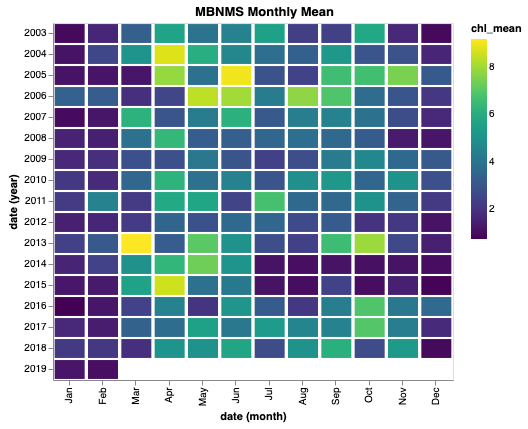

In [78]:
chart = alt.Chart(
    df,
    title="MBNMS Monthly Mean"
).mark_rect().encode(
    x=alt.X('date:O', timeUnit='month'),
    y=alt.Y('date:O', timeUnit='year'),
    color=alt.Color('chl_mean:Q'),
        tooltip=[
        alt.Tooltip('date:T', timeUnit='yearmonth', title='Date'),
        alt.Tooltip('chl_mean:Q',title='CHl-a')
    ]
).properties(width=400)
chart.save('chart.html')
chart

## Altair Cumulative Plots

[Example Plot](https://altair-viz.github.io/gallery/cumulative_wiki_donations.html)

In [65]:
month_sum = grouped.cumsum()
month_sum['date'] = month_sum.index

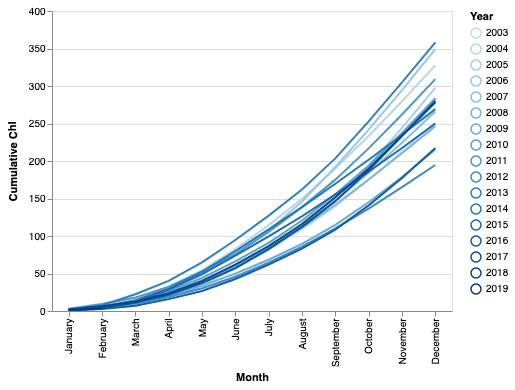

In [74]:
alt.Chart(month_sum).mark_line().encode(
    alt.X('date:O', timeUnit="month", title='Month', axis=alt.Axis(format='%B')),
    alt.Y('cum_sum:Q', title='Cumulative Chl', stack=None),
    alt.Color('year(date):O', legend=alt.Legend(title='Year')),
    alt.Order('year(date):O'),
    tooltip = [
        alt.Tooltip('yearmonth(date)', title='Date'),
        alt.Tooltip('cum_sum:Q',title='Cumulative Chl-a')
    ]
).properties(width=400)